## Using the bottleneck features of a pre-trained network along with data argumentation plus base model fine-tuning for classifying Dog Breeds 

In this short book we will investigate the effect of how data argumentation, transfer learning and fine tuning of pre-trained network can help us achieve high accuracy for predicting the dog breed given a dog image with the additional caveat that we only have a sparse dataset available.

We will consider 133 dogbreeds consisting of:
- 6680 training dog images (avg. of 50 per class)
- 835 validation dog images (avg. of 6 per class)
- 836 test dog images (avg. of 6 per class)


We will start out by transfer learning from imagenet. We check to see the effect of using below optimizer for the transfer learning: <br>
> __model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])__<br>

For fine tuning the last layers in the pre-trained network we use the stochastic gradient descent optimizer with low learning rates (and variable learning rates) and decays while keeping a high momentum of 0.9: <br>
>  __sgd = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)__ <br>
>  __model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])__ <br>

where lr = learning rate

### Xception architecture

The architecture has 36 convolutional stages, illustrated below:
<img src=./Xception_architecture.jpg>

### The Xception model summary

The base model and its layers:

In [1]:
from keras.applications.xception import Xception

base_model = Xception(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
base_model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### The Data

The structure of our training, validation and test datasets are illustrated below. This structure are dictated by using the ImageDataGenerator and flow_from_directory() functionality of Keras, so we need to create a directory structure where images of each class sits within its own sub-directory in the training, validation and test directories.

<img src=./Image_structure_hl.png>

<img src=./Image_structure_ll.png>

<img src=./Image_structure_details.png>

Make sure all the sub-directories (classes) in the training set are present in the validation and test set also. And, remember that the names of the sub-directories will be the names of your classes (labels).

### Constants

The constants of our experiment:

In [2]:
# The pixel size we will use for our images (of various resolution)
WIDTH, HEIGHT = 299, 299

# Number of epochs to train model on
EPOCHS = 5

# Batch size used by flow_from_directory and predict_generator 
BATCH_SIZE = 16

# Note: For each batch, gradients will be computed and updates will be made 
# to the weights of the network automatically. One iteration over all the 
# training set is referred to as an epoch

# Layer from which we will start retraining our already pretrained base model (Xception, Inception or .. whatever)
LAYERS_TO_FREEZE = 126 # We will come in before block 14

# Note for Inception_V3 a suitable value be around NB_IV3 = 172, at least to start with

# The number of outcome classes, that is, number of dog breeds
NO_OF_CLASSES = 133

# location of the directiories containing the same classes
TRAIN_DATA_DIR = 'dogImages/train'
VALID_DATA_DIR = 'dogImages/valid'
TEST_DATA_DIR = 'dogImages/test'

### The top layer

Now we introduce a small fully-connected network - the top model. We will keep the top model small and light as we are only interested in seeing how the transfer learned and the fine tuned models perform.

In [3]:
from keras.models import Model  
from keras.layers import Dropout, Dense, GlobalAveragePooling2D  

top_layer = base_model.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dropout(0.5)(top_layer)
top_layer = Dense(256, activation='relu')(top_layer) 
top_layer = Dropout(0.5)(top_layer)
top_layer = Dense(NO_OF_CLASSES, activation='softmax')(top_layer) 

# Combine the base and top model
model = Model(inputs=base_model.input, outputs=top_layer)

### Preparing for transfer learning

In [4]:
# Freeze all layers in the base model and compile the entire model
def use_transfer_learning():
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Preparing for fine-tuning base model

The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to only fine-tune the last blocks/layers (more specialized features).

In [5]:
from keras.optimizers import SGD

# Allow any layer after LAYERS_TO_FREEZE to get re-trained on our dataset. Fine-tuning 
# should be done with a very slow learning rate, and typically with the SGD optimizer 
# rather than an adaptative learning rate optimizer such as RMSProp. This is to make 
# sure that the magnitude of the updates stays very small, so as not to wreck the 
# previously learned features. 
def use_finetuning(lr, decay):    
    for layer in base_model.layers[:LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in base_model.layers[LAYERS_TO_FREEZE:]:
        layer.trainable = True
    sgd = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### The Image Generators

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [6]:
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, # value in degrees (0-180), a range within which to randomly rotate pictures
    width_shift_range=0.2,  # ranges (fraction of total width or height) within which to randomly translate 
    height_shift_range=0.2, # pictures vertically or horizontally
    zoom_range=0.2, # randomly zooming inside pictures
    horizontal_flip=True # randomly flipping half of the images horizontally
)

# this is the augmentation configuration we will use for training    
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# this is a generator that will read pictures found in subfolders of 'data/train', 
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
)

# this is a similar generator, for validation data
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
)

Found 6650 images belonging to 133 classes.
Found 830 images belonging to 133 classes.


### Training time

In summary:
- to perform fine-tuning, all layers should start with properly trained weights  so we find the weights via transfer learning before fine-tuning, that is, the large gradient updates triggered by randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
- we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
- fine-tuning should typically be done with a slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer 


transfer learning starting...
Epoch 1/5
416/416 [==============================] - 235s - loss: 2.9312 - acc: 0.3665 - val_loss: 0.9408 - val_acc: 0.7398
Epoch 2/5
416/416 [==============================] - 233s - loss: 1.3706 - acc: 0.6132 - val_loss: 0.7342 - val_acc: 0.7598
Epoch 3/5
416/416 [==============================] - 233s - loss: 1.1035 - acc: 0.6800 - val_loss: 0.6168 - val_acc: 0.8032
Epoch 4/5
416/416 [==============================] - 233s - loss: 1.0246 - acc: 0.7088 - val_loss: 0.5880 - val_acc: 0.8092
Epoch 5/5
416/416 [==============================] - 233s - loss: 0.9716 - acc: 0.7214 - val_loss: 0.5696 - val_acc: 0.8133


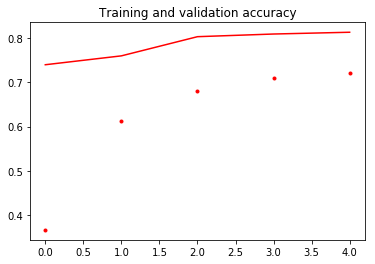

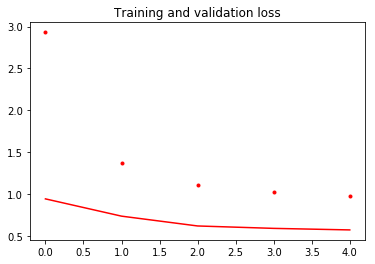

fine-tuning starting...
Epoch 1/10
416/416 [==============================] - 244s - loss: 0.8088 - acc: 0.7606 - val_loss: 0.5355 - val_acc: 0.8273
Epoch 2/10
416/416 [==============================] - 243s - loss: 0.7496 - acc: 0.7693 - val_loss: 0.4978 - val_acc: 0.8369
Epoch 3/10
416/416 [==============================] - 243s - loss: 0.7082 - acc: 0.7836 - val_loss: 0.5010 - val_acc: 0.8386
Epoch 4/10
416/416 [==============================] - 243s - loss: 0.6937 - acc: 0.7861 - val_loss: 0.4853 - val_acc: 0.8474
Epoch 5/10
416/416 [==============================] - 243s - loss: 0.6646 - acc: 0.7986 - val_loss: 0.4670 - val_acc: 0.8510
Epoch 6/10
416/416 [==============================] - 243s - loss: 0.6272 - acc: 0.8069 - val_loss: 0.4545 - val_acc: 0.8494
Epoch 7/10
416/416 [==============================] - 243s - loss: 0.5950 - acc: 0.8104 - val_loss: 0.4710 - val_acc: 0.8494
Epoch 8/10
416/416 [==============================] - 243s - loss: 0.6117 - acc: 0.8115 - val_loss: 0

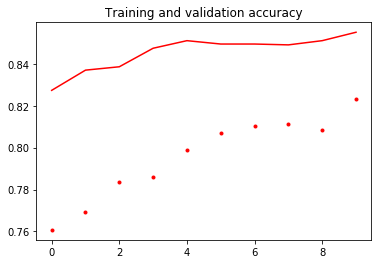

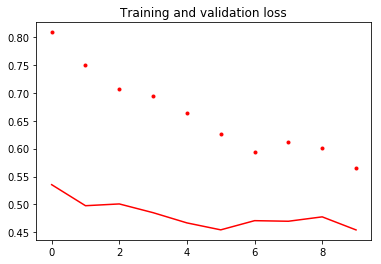

In [7]:
import math
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

# A little plot helper allowing us to visualise the result
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

# A continuously decreasing learning rate schedule
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another stepped decreasing learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Use transfer learning and fine-tuning to train a network on a given dataset
def train():
    no_of_train_samples = len(train_generator.filenames)
    no_of_valid_samples = len(valid_generator.filenames)

    # We calculate the number of itrations ourselves as there are a small bug in predict_generator
    # and fit_generator when working on batches when the number of samples are not divisible
    # by the batch size
    no_of_train_iterations = int(math.ceil(no_of_train_samples / BATCH_SIZE))  
    no_of_valid_iterations = int(math.ceil(no_of_valid_samples / BATCH_SIZE))*3 

    print("transfer learning starting...")
    use_transfer_learning()
    history_tl = model.fit_generator(
        train_generator,
        steps_per_epoch=no_of_train_iterations,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=no_of_valid_iterations,
        verbose=1)    
    plot_training(history_tl)

    print("fine-tuning starting...")
    use_finetuning(lr=7e-4, decay=1e-5)
    history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=no_of_train_iterations,
        epochs=2*EPOCHS,
        validation_data=valid_generator,
        validation_steps=no_of_valid_iterations,
        verbose=1)    
    plot_training(history_ft)

    
# Lets train away
train()


### Final test result

In [8]:
from keras.preprocessing import image    
from sklearn.datasets import load_files  
from keras.utils import np_utils
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), NO_OF_CLASSES)
    return dog_files, dog_targets

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(WIDTH, HEIGHT))
    # convert PIL.Image.Image type to 3D tensor with shape (WIDTH, HEIGHT, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, WIDTH, HEIGHT, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_files, test_targets = load_dataset(TEST_DATA_DIR)
# Pre-process the data for Keras
test_tensors = paths_to_tensor(test_files).astype('float32')/255

# Get index of predicted dog breed for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

100%|██████████| 836/836 [00:06<00:00, 131.12it/s]


Test accuracy: 88.3971%


In [10]:
from extract_bottleneck_features import *
from keras.applications.xception import preprocess_input, decode_predictions
from glob import glob

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# Returns a vector containing all dog breeds and for each dog breed a probability of the provided image 
# matching that particular dog breed class.
def Xception_predictions(img_path):
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    print(predicted_vector)
    return predicted_vector

# Given any image returns the closest resembling dog breed
def resembling_dog_breed(img_path):
    predicted_vector = Xception_predictions(img_path)
    return dog_names[np.argmax(predicted_vector)]

my_dog_images = ["images/Alfie-JackRussel.jpg", "images/Alfie-JackRussel_1.jpg", "images/Trex-YorkshireTerrier.jpg", "images/Trex-YorkshireTerrier_1.jpg"]
for dog_image in my_dog_images:
    print(dog_image)
    print(resembling_dog_breed(dog_image))

my_family_images = ["images/John.jpg", "images/Sue.jpg", "images/Sue1.jpg", "images/Oscar.jpg"]
for family_image in my_family_images:
    print(family_image)
    print(resembling_dog_breed(family_image))
    
# Images without humans, pets or animals, just 'dead' things
other_images = ["images/Sample_CNN.png", "images/Square.png", "images/Galaxy.jpg"]
for other_image in other_images:
    print(other_image)
    print(resembling_dog_breed(other_image))

images/Alfie-JackRussel.jpg
[[  2.10856001e-07   4.12815071e-09   1.90427855e-07   9.59704994e-05
    5.85709415e-07   1.85751844e-06   6.47896959e-04   3.31392020e-01
    4.43459278e-08   2.58236687e-04   3.76326352e-06   3.02937024e-05
    3.52123237e-07   2.55432060e-05   1.27998305e-06   2.39659494e-04
    2.35434800e-06   7.13063628e-07   1.23907671e-06   5.04377624e-08
    7.74832145e-08   9.61040136e-09   2.81406081e-08   2.72992452e-06
    7.30000504e-09   1.52686468e-08   1.01352464e-08   3.08194039e-08
    9.83038626e-06   2.43137742e-06   1.71358188e-05   3.02612875e-06
    2.35208915e-07   1.96923083e-05   2.85520425e-08   3.67433330e-07
    1.36351897e-04   6.20509013e-07   1.11981630e-02   3.15738696e-04
    6.58528552e-06   1.34649190e-05   1.88683043e-03   1.25839142e-04
    9.59311001e-06   1.80429680e-07   1.98215889e-06   1.93564156e-05
    1.00546379e-06   2.84705147e-05   2.29722616e-07   3.94548977e-07
    3.44684636e-08   1.17195739e-07   2.65699125e-08   4.63617

[[ 0.00671327  0.0115557   0.00619163  0.01370979  0.00309523  0.00231925
   0.00462362  0.0042687   0.00287178  0.00224115  0.00545279  0.00841064
   0.00610415  0.00409055  0.01161014  0.00379717  0.00647594  0.00281616
   0.0027668   0.00873152  0.00828786  0.0052069   0.00259724  0.00402183
   0.00227354  0.00495422  0.00690933  0.00158074  0.00258812  0.0009346
   0.00552813  0.01864189  0.00788027  0.00585171  0.00304227  0.00841685
   0.00483042  0.01274572  0.00854075  0.01641008  0.00374635  0.00144201
   0.01693078  0.00476879  0.03048354  0.02537743  0.00410515  0.02213579
   0.09004343  0.00311478  0.00217735  0.00055572  0.00202264  0.01045584
   0.00256934  0.03361588  0.01013339  0.00066066  0.00915125  0.00412262
   0.00281737  0.00299463  0.00334446  0.02568439  0.00219486  0.00166131
   0.01097341  0.00276869  0.01837747  0.0116198   0.00578512  0.00358469
   0.00111362  0.00533647  0.00194663  0.0027325   0.00125451  0.01139002
   0.00272526  0.00112355  0.00825494  

Great success but maybe we can do better by considering:
- use of L1 or L2 regularization (https://keras.io/regularizers/)
- better loss function
- more aggresive data augmentation
- more aggressive dropout
- fine-tuning additional convolutional block/layers
- batch normalisation
- use ensembles (avg. multiple models)